In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import folder_handling as fh

reload(fh)

<module 'folder_handling' from 'folder_handling.pyc'>

In [3]:
#path_to_raw_photo = "../../images/color_experiments/experiment_2/raw_photo"
#fh.compress_photos(path_to_raw_photo)
path_compressed = "../../images/color_experiments/experiment_2/compressed/"

In [4]:
exp = fh.Experiment()

In [5]:
exp.load_images(path_compressed,char_to_split_color_name=".")

Отобразим сжатые изображения.

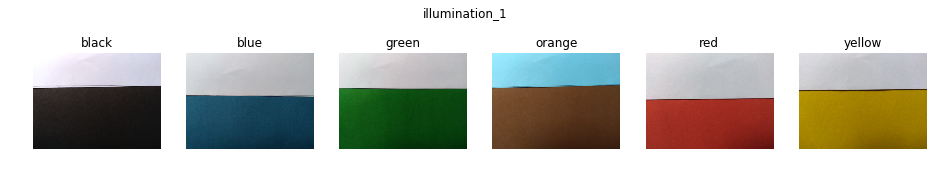

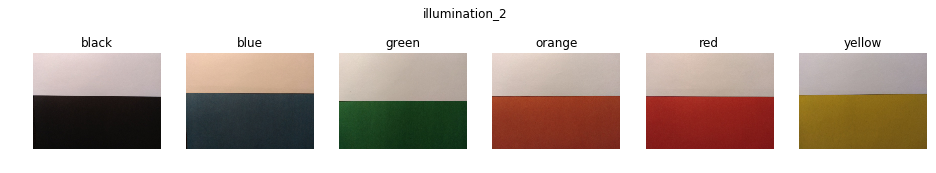

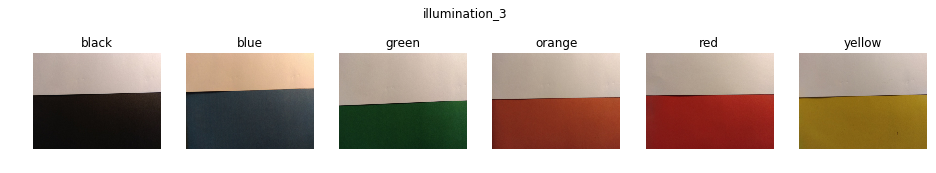

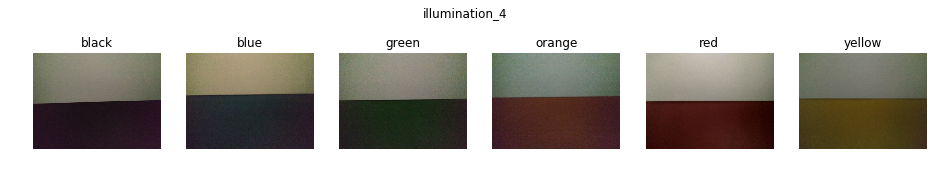

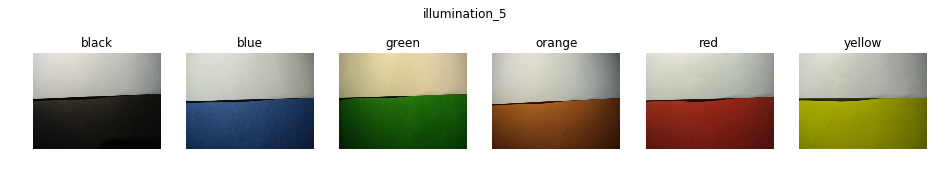

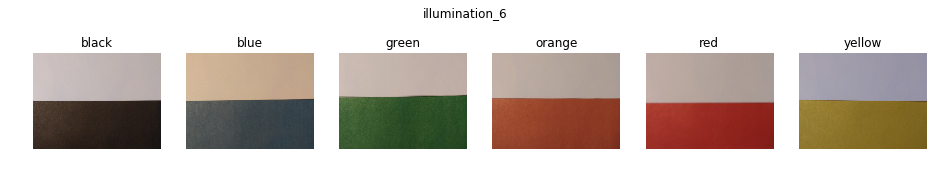

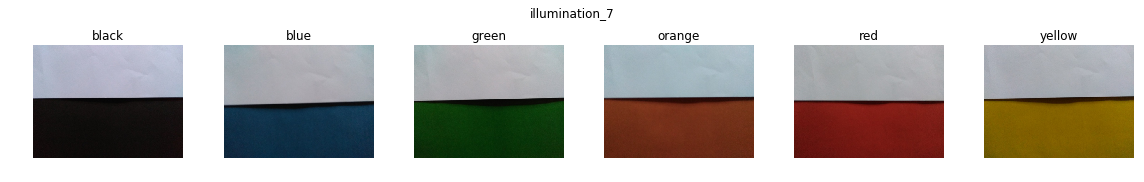

In [6]:

for name,Illum in sorted(exp.illuminations.iteritems()):
    plt.figure(figsize=(16,6))
    
    for i,color in enumerate(Illum.images):
        n_colors = len(Illum.images)
        plt.subplot(1,n_colors,i+1)
        img = Illum.images[color][0]
        plt.imshow(img)
        plt.title(color)
        plt.axis('off')
    plt.suptitle(Illum.name,x=0.5,y=0.72)
plt.tight_layout()

Отлично, все фотографии выглядят более-менее одинаково (ничего не надо разворачивать). 

Попробуем по верхней части (четверти, для начала), оценить баланс белого на фотографии, чтобы подтянуть все каналы

In [7]:
def get_white_part(img,n=4):
    return img[:img.shape[0]//n,:,:]

def get_nonwhite_part(img,n=4):
    return img[-img.shape[0]//n:,:,:]

def compute_rw_gw_bw(img_w):
    rw,gw,bw = img_w.mean(axis=(0,1))
    
    return rw,gw,bw

In [8]:
adjusted_images = {} # color: list of images of same 
raw_images = {}
print "Check to preserve order"
for name,illum in sorted(exp.illuminations.iteritems()):
    
    print "Adding image from ", name
    for color in illum.images:
        img = illum.images[color][0]
        
        if color not in adjusted_images:
            adjusted_images[color] = []
            raw_images[color] = []
        img_w = get_white_part(img)
        img_nw = get_nonwhite_part(img)
        colors_w = compute_rw_gw_bw(img_w)
        adj_img = fh.adjust_white_balance_wrt_rgb(img_nw,colors_w)
        
        adjusted_images[color].append(adj_img)
        raw_images[color].append(img)

Check to preserve order
Adding image from  illumination_1
Adding image from  illumination_2
Adding image from  illumination_3
Adding image from  illumination_4
Adding image from  illumination_5
Adding image from  illumination_6
Adding image from  illumination_7


Выведем скорректированные по балансу белого изображения

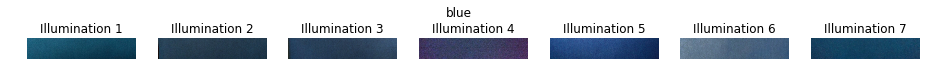

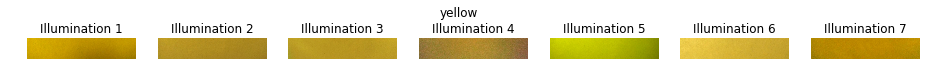

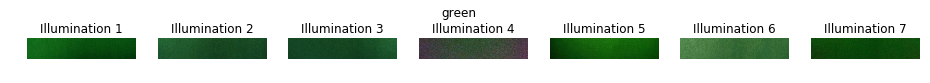

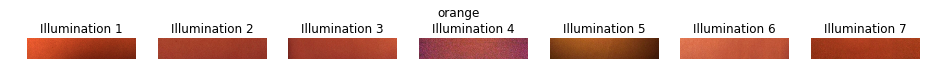

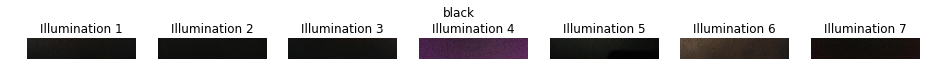

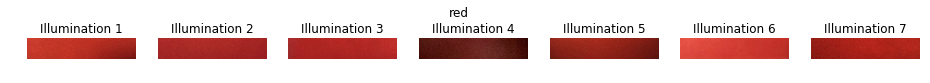

In [9]:
for color in adjusted_images:
    n_images = len(adjusted_images[color])
    plt.figure(figsize=(16,6))
    
    for i,img in enumerate(adjusted_images[color]):
        plt.subplot(1,n_images,i+1)
        
        plt.imshow(img)
        plt.title('Illumination {}'.format(i+1))
        plt.axis('off')
    plt.suptitle(color,x=0.5,y=0.6)

Посмотрим на гистограммы распределений цвета на скорректированных изображениях с различным освещением

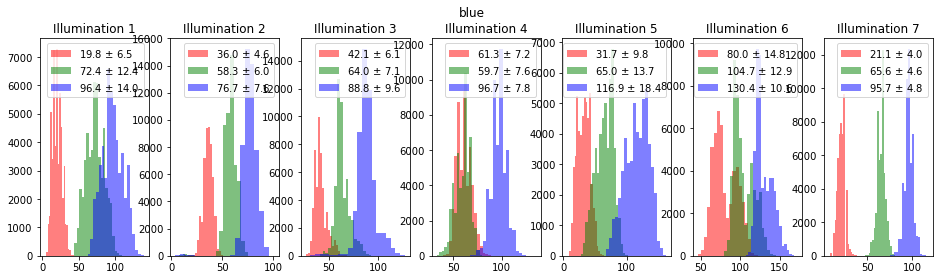

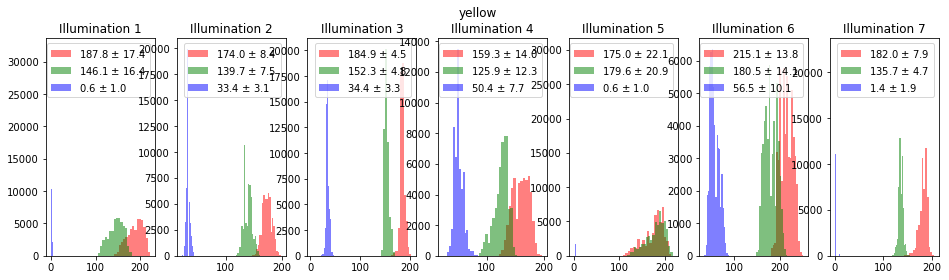

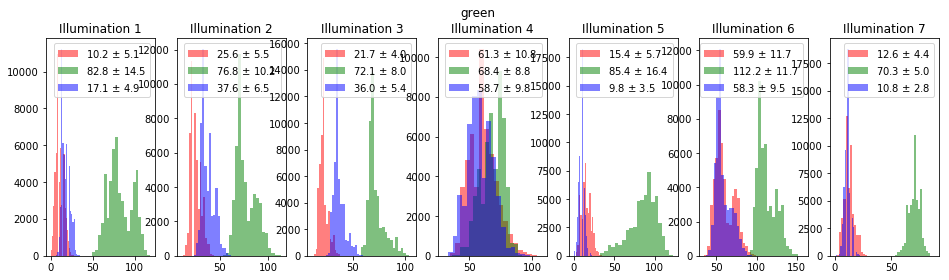

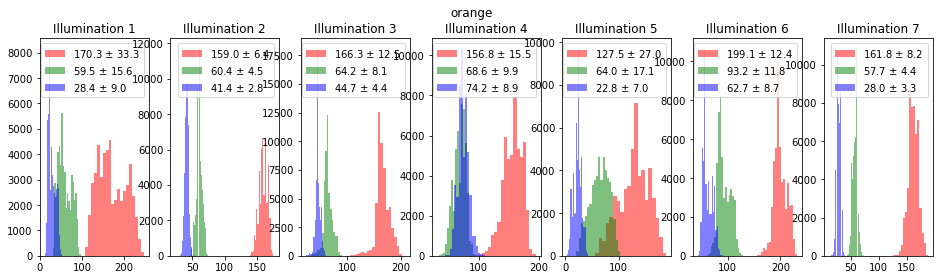

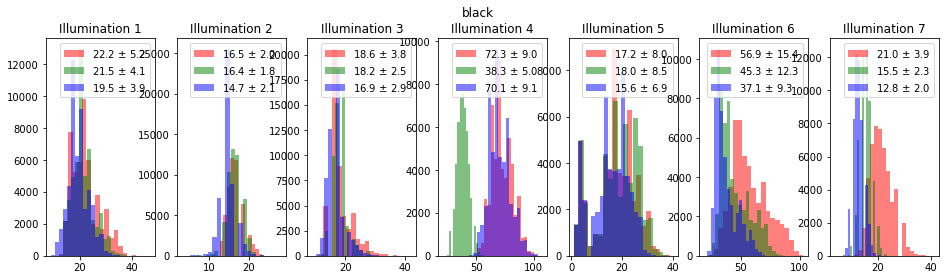

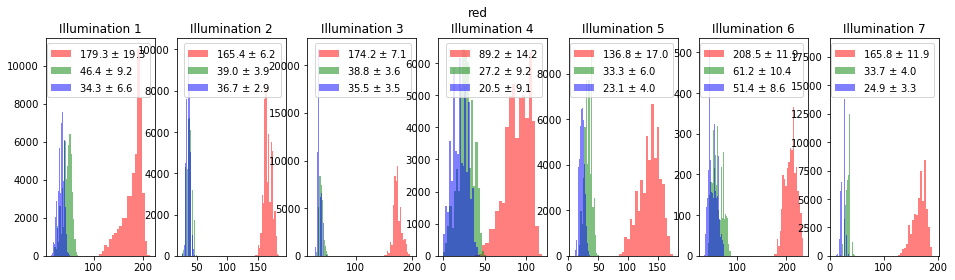

In [10]:
for color in adjusted_images:
    n_images = len(adjusted_images[color])
    plt.figure(figsize=(16,4))
    
    for i,img in enumerate(adjusted_images[color]):
        plt.subplot(1,n_images,i+1)
        
        fh.plot_color_hist(img)
        plt.title('Illumination {}'.format(i+1))
        plt.legend()
    plt.suptitle(color,x=0.5,y=0.99)

In [11]:
import seaborn as sns
import pandas as pd
sns.set_style('whitegrid')

In [12]:
def get_color_dataframes(adjusted_images):
    """
    takes dict k:color-name v: img (np.array with shape = (height,width,channels))
    and create dict of dataframes with three columns:
    value of channel, name of channel and name of illumination
    """
    color_dataframes = {}

    for color in adjusted_images:

        data = pd.DataFrame(columns=["val","channel","illumination"])
        for i,img in enumerate(adjusted_images[color]):
            r_val = np.ravel(img[:,:,0])
            g_val = np.ravel(img[:,:,1])
            b_val = np.ravel(img[:,:,2])
            r_name = np.array(['r']*r_val.shape[0])
            g_name = np.array(['g']*g_val.shape[0])
            b_name = np.array(['b']*b_val.shape[0])
            raveled_img = np.hstack((r_val,g_val,b_val))
            channel_name = np.hstack((r_name,g_name,b_name))

            illum = np.array(['illum_{}'.format(i+1)]*raveled_img.shape[0])
            data2 = pd.DataFrame({"val":raveled_img,
                         "channel":channel_name,
                         "illumination":illum})

            data = data.append(data2,ignore_index=True)

        color_dataframes[color] = data
    return color_dataframes

In [13]:
color_dataframes = get_color_dataframes(adjusted_images)

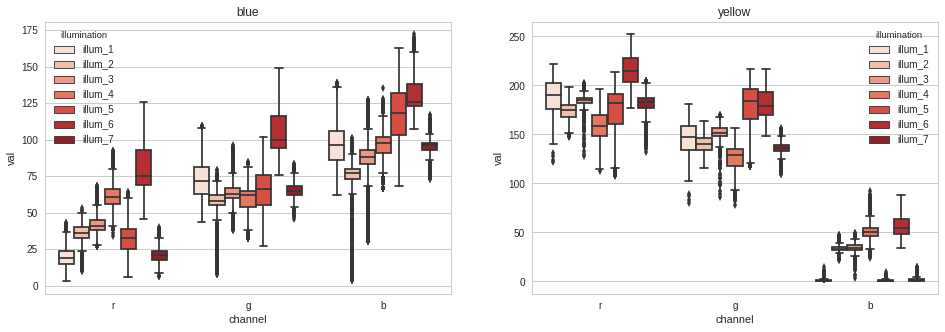

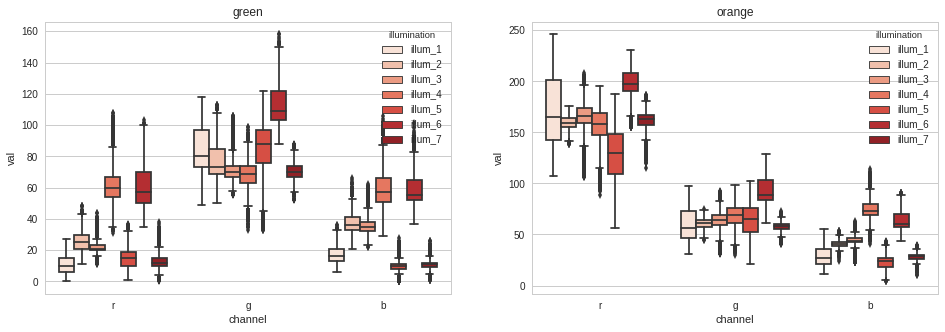

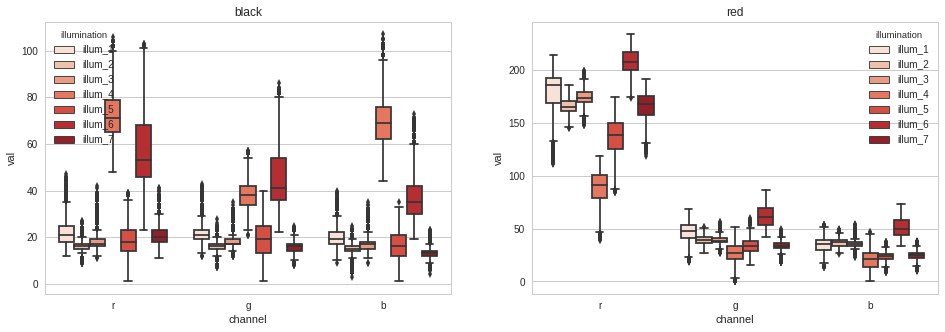

In [14]:

for i,color in enumerate(color_dataframes):
    
    if i%2 == 0:
        plt.figure(figsize=(16,5))
    plt.subplot(1,2,i%2 + 1)
    sns.boxplot(x="channel",y="val",hue="illumination",palette="Reds",data=color_dataframes[color])
    plt.title(color)

In [15]:
PRO_points = [
    (220, 233, 119),
    (186, 211, 109),
    (165, 193, 119),
    (144, 185, 145),
    (112, 175, 154),
    (89, 156, 138),
]

PRO_points = np.array(PRO_points)

In [16]:
def get_full_dataframe(color_dataframes):
    full_data = pd.DataFrame(columns = ['channel','illumination','val','color'])

    for color in color_dataframes:
        data = color_dataframes[color]
        data['color'] = [color]*data.shape[0]
        full_data = full_data.append(data)
        
    return full_data

In [17]:
full_data = get_full_dataframe(color_dataframes=color_dataframes)

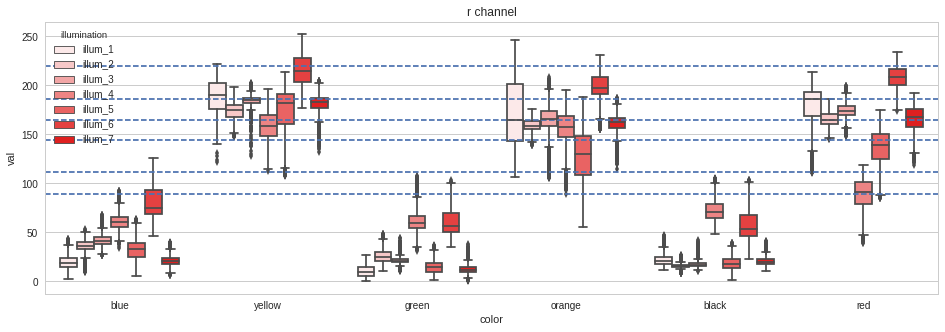

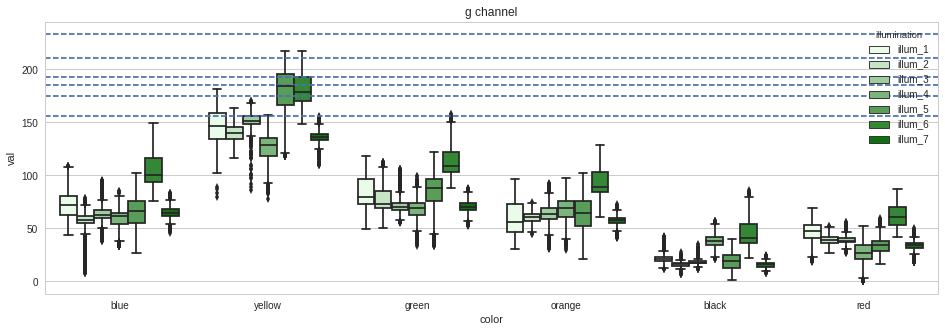

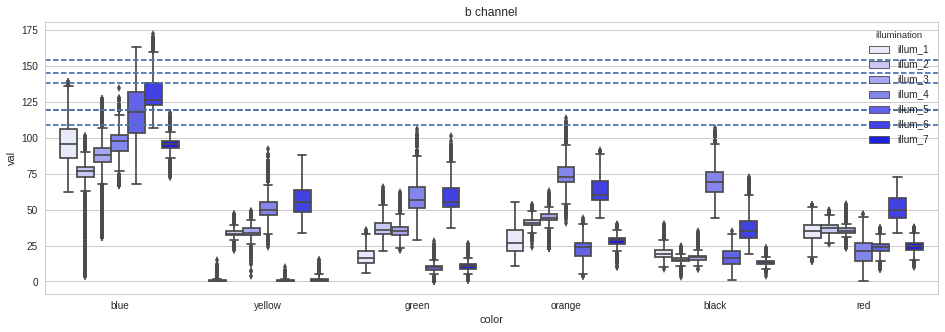

In [55]:
def plot_wrt_calibration(full_data,points):
    for i,c in enumerate(['r','g','b']):
        plt.figure(figsize=(16,5))
        sns.boxplot(x='color',y='val',hue='illumination',color=c,data = full_data[full_data['channel']==c])
        for j in xrange(points.shape[0]):
            plt.axhline(y=points[j,i],linestyle="dashed",label="PRO {} values".format(c))
        plt.title('{} channel'.format(c))
    plt.show()
    
plot_wrt_calibration(full_data,PRO_points)


def plot_boxplotes_by_channels(full_data):
    for i,c in enumerate(['r','g','b']):
        plt.figure(figsize=(16,5))
        sns.boxplot(x='color',y='val',hue='illumination',color=c,data = full_data[full_data['channel']==c])
        plt.title('{} channel'.format(c))
    plt.show()
    

Тестирование различных алгоритмов
---------

**Вопросы, на которые хотелось бы ответить:**

1) Выравнивание по каждому каналу вида: $$ algo_1(x) = \frac{(255 - 0)}{(x_{max} - x_{min})} * (x - x_{min}) $$ где x - интенсивность в пикселе в каждом канале 

2) Как влияет автофокус на баланс белого камеры?

In [109]:
def apply_algo(raw_images,algo):
    """
    takes dict of list of raw images and algorithm as an argument 
    and returns dict of list of adjusted images wrt to algorithm
    """
    adjusted_images_algo = {}
    
    for color, images in raw_images.iteritems():
        adjusted_images_algo[color] = []
        for img in images:
            adjusted_images_algo[color].append(algo(img))
            
    return adjusted_images_algo


def plot_comparison(raw_nonwhite_part,adj_img_algo):
    """
        takes dict of raw_nonwhite_part list of images and adjusted nonwhite part 
        and then plot boxplots of r g b values for different colors and illuminations
    """
    color_coordinates = []
    color_ticks = []
    ar,ag,ab = [],[],[]
    ar_std,ag_std,ab_std = [],[],[]
    
    rr,rg,rb = [],[],[]
    rr_std,rg_std,rb_std = [],[],[]
    
    n_illuminations = None
    for i,color in enumerate(sorted(adj_img_algo)):
        raw_images = raw_nonwhite_part[color]
        adj_images = adj_img_algo[color]
        
        for r_img, a_img in zip(raw_images,adj_images):
            rr.append(r_img[:,:,0].mean())
            rg.append(r_img[:,:,1].mean())
            rb.append(r_img[:,:,2].mean())
            
            rr_std.append(r_img[:,:,0].std())
            rg_std.append(r_img[:,:,1].std())
            rb_std.append(r_img[:,:,2].std())
            
            ar.append(a_img[:,:,0].mean())
            ag.append(a_img[:,:,1].mean())
            ab.append(a_img[:,:,2].mean())
            
            ar_std.append(a_img[:,:,0].std())
            ag_std.append(a_img[:,:,1].std())
            ab_std.append(a_img[:,:,2].std())
            
            
        n_illuminations = len(raw_images)
        
        color_coordinates.extend((i+np.linspace(-0.2,0.2,num=n_illuminations)))
        color_ticks.append(color)
    
    channel_names = ["red","green","blue"]
    means = [(ar,rr),(ag,rg),(ab,rb)]
    stds = [(ar_std,rr_std),(ag_std,rg_std),(ab_std,rb_std)]
    for i,((a,r),(a_std,r_std)) in enumerate(zip(means,stds)):
        plt.figure(figsize=(10,5))
        plt.errorbar(color_coordinates,a,yerr=a_std,c='red',fmt='o',label='corrected')
        plt.errorbar(color_coordinates,r,yerr=r_std,c='blue',fmt='o',label='raw')
        plt.xticks(range(len(color_ticks)),color_ticks)
        plt.title('{} channel'.format(channel_names[i]))
        plt.xlabel('colors')
        plt.ylabel('channel value')
        plt.legend()

    plt.show()

In [135]:
def algo_1(raw_img):
    new_img = np.zeros(raw_img.shape).astype('uint8')
    for i in xrange(raw_img.shape[-1]):
        x_max = np.max(raw_img[:,:,i])
        x_min = np.min(raw_img[:,:,i])
        new_img[:,:,i] = ((255. - 0.)/(x_max - x_min))*(raw_img[:,:,i] - x_min)
    
    new_img = get_nonwhite_part(new_img)
    return new_img.astype('uint8')

In [136]:
def algo_2(raw_img):
    white_part = get_white_part(raw_img)
    non_white_part = get_nonwhite_part(raw_img)
    rw_gw_bw = white_part.mean(axis=(0,1))
    adj_img = fh.adjust_white_balance_wrt_rgb(raw_img,rw_gw_bw)
    
    return algo_1(adj_img)

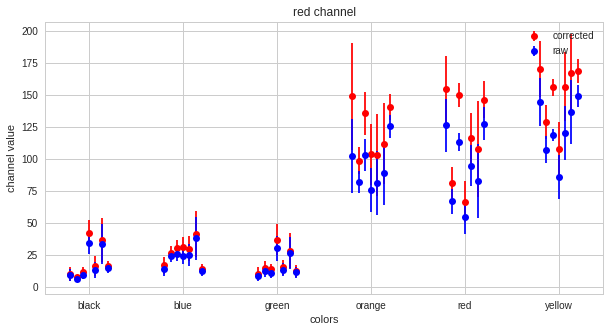

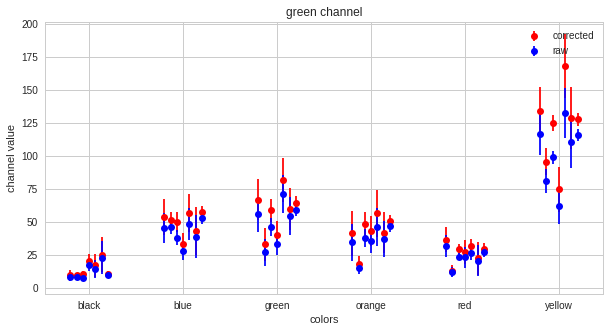

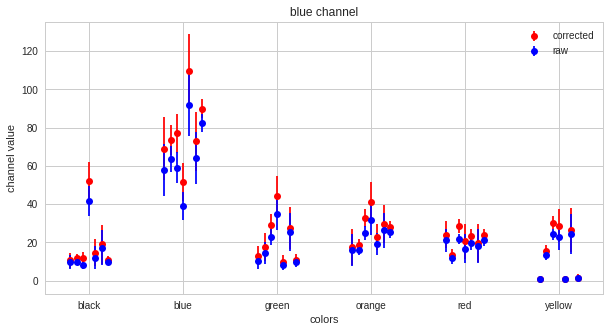

In [138]:
plot_comparison(adj_img_algo_1,adj_img_algo_2)

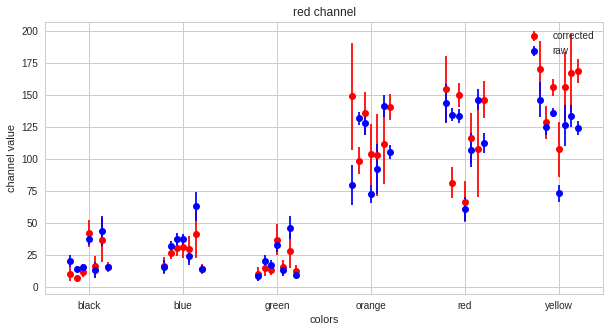

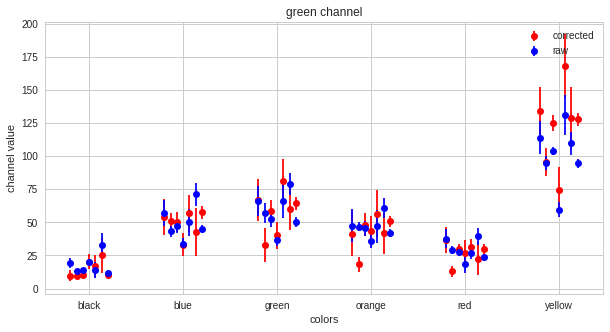

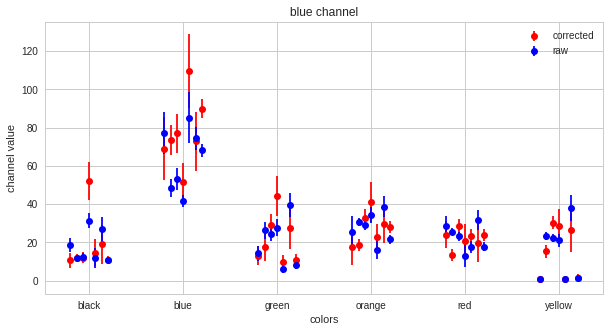

In [137]:
plot_comparison(raw_nonwhite_part,adj_img_algo_2)

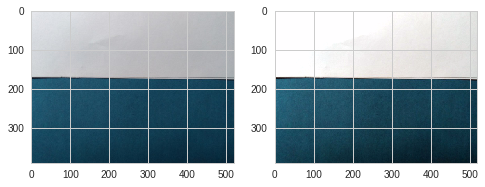

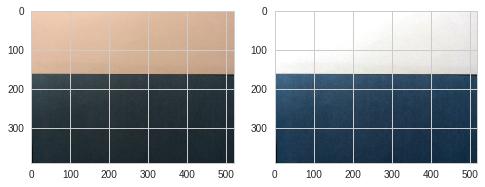

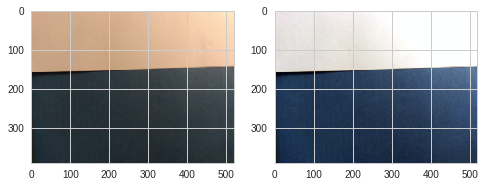

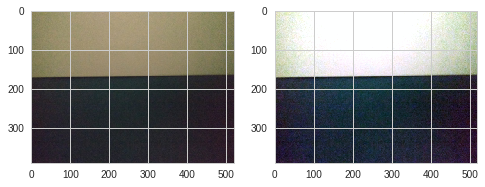

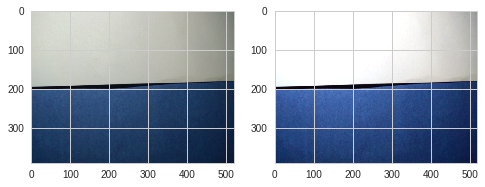

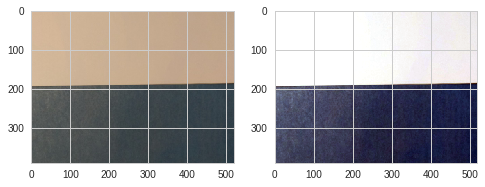

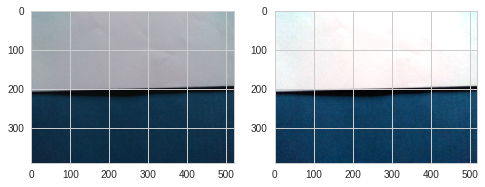

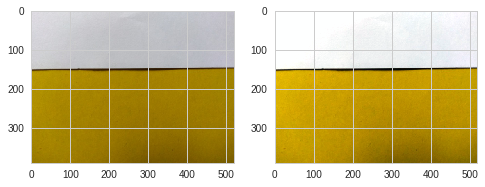

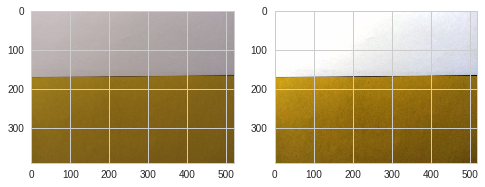

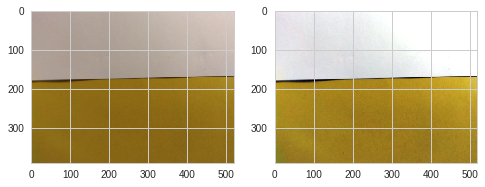

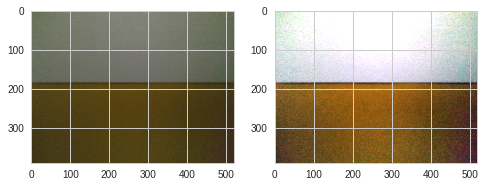

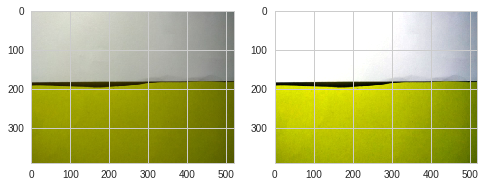

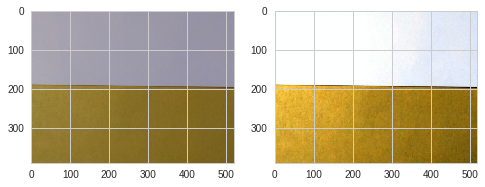

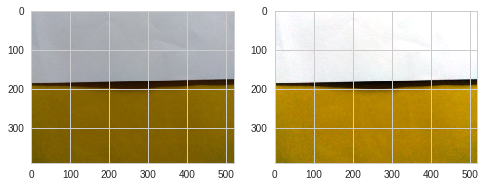

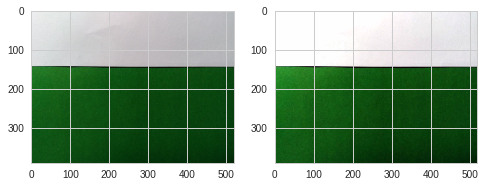

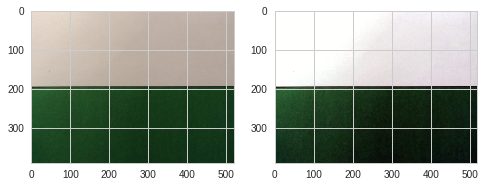

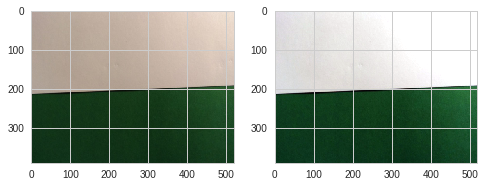

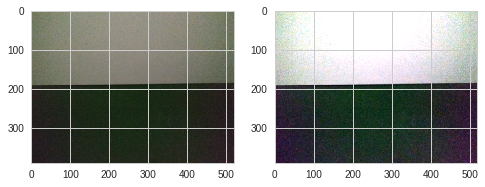

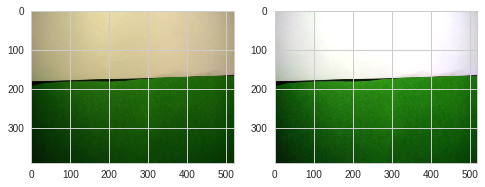

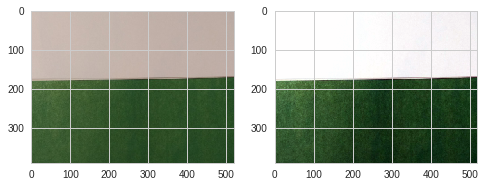

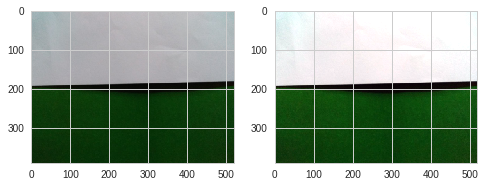

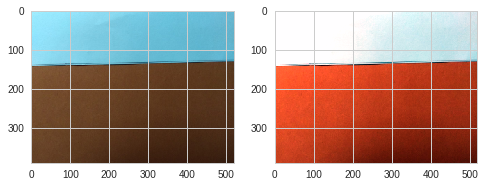

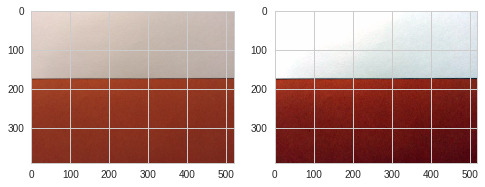

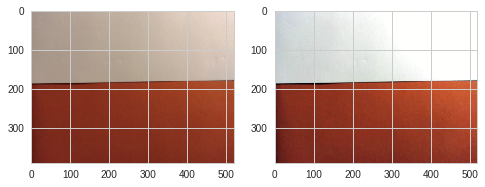

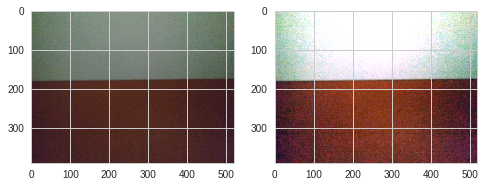

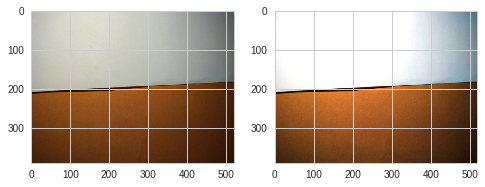

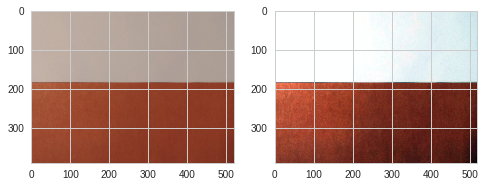

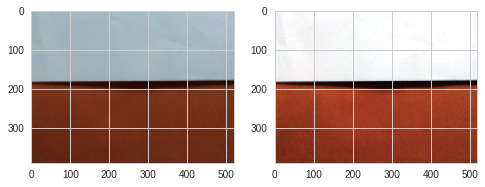

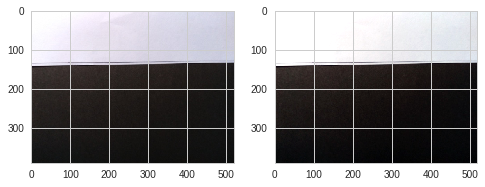

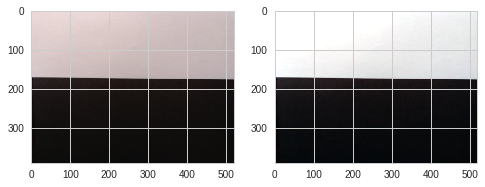

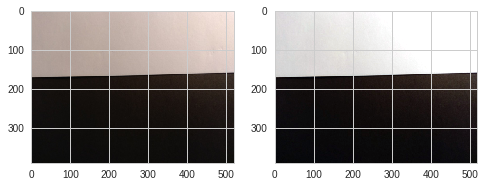

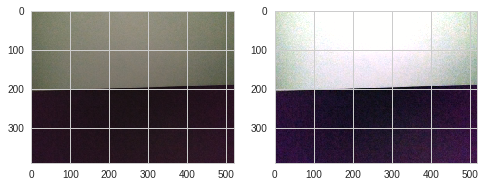

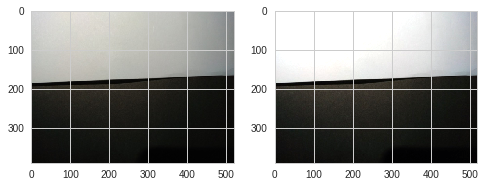

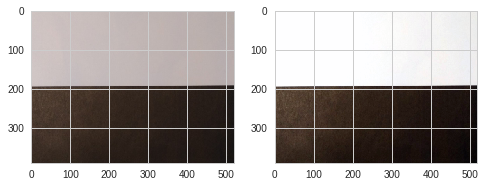

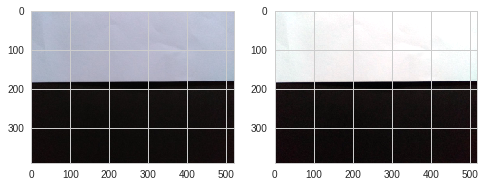

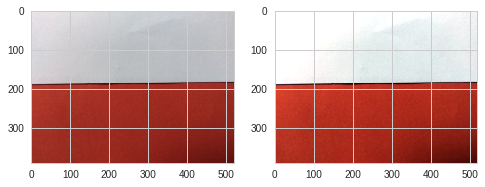

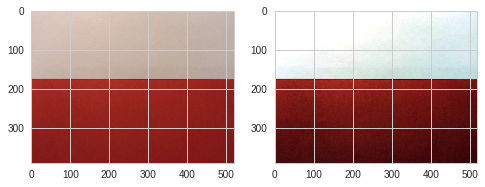

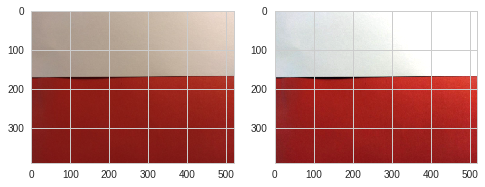

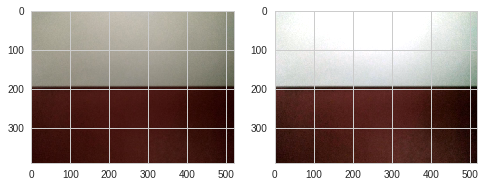

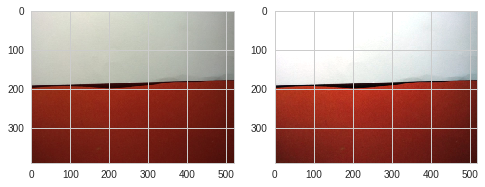

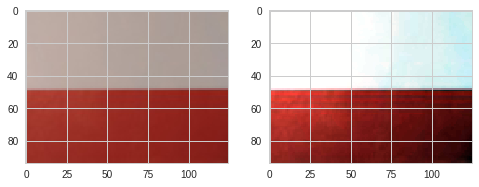

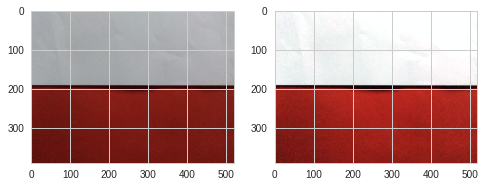

In [134]:
for color in raw_images:
    for r_img in raw_images[color]:
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(r_img)
        plt.subplot(1,2,2)
        plt.imshow(algo_2(r_img))

In [111]:
adj_img_algo_1= apply_algo(raw_images,algo=algo_1)

In [127]:
adj_img_algo_2 = apply_algo(raw_images,algo=algo_2)

In [112]:
raw_nonwhite_part = apply_algo(raw_images,get_nonwhite_part)

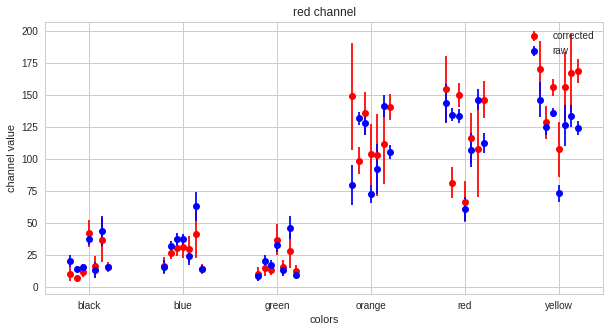

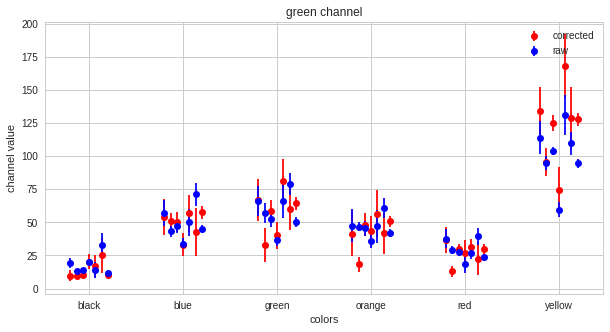

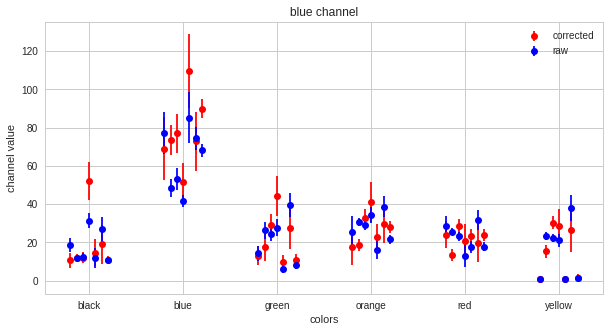

In [128]:
plot_comparison(raw_nonwhite_part,adj_img_algo_2)